In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa
import torch.utils.data as td
import torchvision as tv
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

In [ ]:
os.chdir('./drive/MyDrive/hack/')

In [ ]:
%%time
!unzip "./data.zip" -d "/content/drive/MyDrive/hack/data/"

In [2]:
def imshow(img):
  img = img   # unnormalize
  
  # cv2_imshow(images[0][0])
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
  
  plt.show()

In [3]:
transform = transforms.Compose([
                                transforms.ColorJitter(brightness=.3),
#                                 transforms.RandomRotation(20),
                                transforms.Resize((256,256)), 
                                transforms.RandomVerticalFlip(0.3),
                                transforms.RandomHorizontalFlip(0.3),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),                                
                               ])


valid_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]), 
    ])

In [4]:
train_dataset=datasets.ImageFolder('./data1/train/',transform=transform)
valid_dataset=datasets.ImageFolder('./data1/valid/',transform=valid_transforms)

In [7]:
len(valid_dataset)

1016

In [8]:
# prepare data loaders (combine dataset and sampler)
batch_size=24
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [10]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [236]:
!pip install efficientnet_pytorch

In [11]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=5)

Loaded pretrained weights for efficientnet-b3


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [75]:
# number of epochs to train the model
n_epochs = 200

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in tqdm(train_dataloader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_dataloader)
    train_acc[e] /= len(train_dataloader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in tqdm(valid_dataloader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(valid_dataloader)
    valid_acc[e] /= len(valid_dataloader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'hackaton1.pt')
        valid_loss_min = valid_loss[e]

  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.108537 	Validation Loss: 0.093714
Epoch: 0 	Training accuracy: 0.966597 	Validation accuracy: 0.979651
Validation loss decreased (inf --> 0.093714).  Saving model ...


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.060653 	Validation Loss: 0.041470
Epoch: 1 	Training accuracy: 0.981093 	Validation accuracy: 0.988372
Validation loss decreased (0.093714 --> 0.041470).  Saving model ...


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.034761 	Validation Loss: 0.066994
Epoch: 2 	Training accuracy: 0.989356 	Validation accuracy: 0.984496


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.049124 	Validation Loss: 0.067834
Epoch: 3 	Training accuracy: 0.983964 	Validation accuracy: 0.980620


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.039509 	Validation Loss: 0.046953
Epoch: 4 	Training accuracy: 0.987045 	Validation accuracy: 0.981589


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.032008 	Validation Loss: 0.053049
Epoch: 5 	Training accuracy: 0.989986 	Validation accuracy: 0.989341


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.039603 	Validation Loss: 0.048865
Epoch: 6 	Training accuracy: 0.987255 	Validation accuracy: 0.988372


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.022380 	Validation Loss: 0.097961
Epoch: 7 	Training accuracy: 0.993697 	Validation accuracy: 0.976744


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.025722 	Validation Loss: 0.031893
Epoch: 8 	Training accuracy: 0.992227 	Validation accuracy: 0.994186
Validation loss decreased (0.041470 --> 0.031893).  Saving model ...


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.022892 	Validation Loss: 0.035728
Epoch: 9 	Training accuracy: 0.993418 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.031926 	Validation Loss: 0.284753
Epoch: 10 	Training accuracy: 0.990546 	Validation accuracy: 0.937015


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.027112 	Validation Loss: 0.042638
Epoch: 11 	Training accuracy: 0.991597 	Validation accuracy: 0.988372


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.019276 	Validation Loss: 0.047389
Epoch: 12 	Training accuracy: 0.993908 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.022511 	Validation Loss: 0.040109
Epoch: 13 	Training accuracy: 0.992577 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.026626 	Validation Loss: 0.052204
Epoch: 14 	Training accuracy: 0.992157 	Validation accuracy: 0.987403


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.014225 	Validation Loss: 0.050042
Epoch: 15 	Training accuracy: 0.996009 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.019171 	Validation Loss: 0.068172
Epoch: 16 	Training accuracy: 0.994187 	Validation accuracy: 0.985465


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.037199 	Validation Loss: 0.043276
Epoch: 17 	Training accuracy: 0.990827 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.014761 	Validation Loss: 0.053521
Epoch: 18 	Training accuracy: 0.995308 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.013987 	Validation Loss: 0.049700
Epoch: 19 	Training accuracy: 0.995728 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.004159 	Validation Loss: 0.057926
Epoch: 20 	Training accuracy: 0.998389 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.002139 	Validation Loss: 0.056996
Epoch: 21 	Training accuracy: 0.999370 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.002515 	Validation Loss: 0.058549
Epoch: 22 	Training accuracy: 0.999020 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.001958 	Validation Loss: 0.071993
Epoch: 23 	Training accuracy: 0.999510 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.001652 	Validation Loss: 0.059396
Epoch: 24 	Training accuracy: 0.999440 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.000923 	Validation Loss: 0.061884
Epoch: 25 	Training accuracy: 0.999790 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.001709 	Validation Loss: 0.060954
Epoch: 26 	Training accuracy: 0.999370 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.000459 	Validation Loss: 0.061739
Epoch: 27 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.001567 	Validation Loss: 0.058763
Epoch: 28 	Training accuracy: 0.999580 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.001184 	Validation Loss: 0.063085
Epoch: 29 	Training accuracy: 0.999720 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.000500 	Validation Loss: 0.066424
Epoch: 30 	Training accuracy: 0.999860 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.000282 	Validation Loss: 0.068636
Epoch: 31 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.000257 	Validation Loss: 0.067746
Epoch: 32 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.000644 	Validation Loss: 0.067532
Epoch: 33 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.000376 	Validation Loss: 0.066954
Epoch: 34 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.000566 	Validation Loss: 0.067223
Epoch: 35 	Training accuracy: 0.999790 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.000497 	Validation Loss: 0.066322
Epoch: 36 	Training accuracy: 0.999860 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.000260 	Validation Loss: 0.066492
Epoch: 37 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.000305 	Validation Loss: 0.066640
Epoch: 38 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.000312 	Validation Loss: 0.067816
Epoch: 39 	Training accuracy: 0.999860 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.000273 	Validation Loss: 0.067810
Epoch: 40 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.000299 	Validation Loss: 0.068183
Epoch: 41 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.001887 	Validation Loss: 0.068522
Epoch: 42 	Training accuracy: 0.999510 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.000433 	Validation Loss: 0.067229
Epoch: 43 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.000414 	Validation Loss: 0.068318
Epoch: 44 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.000141 	Validation Loss: 0.068254
Epoch: 45 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.000213 	Validation Loss: 0.069329
Epoch: 46 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.000294 	Validation Loss: 0.068915
Epoch: 47 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.000150 	Validation Loss: 0.068381
Epoch: 48 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.000224 	Validation Loss: 0.067913
Epoch: 49 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.000244 	Validation Loss: 0.078989
Epoch: 50 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.000144 	Validation Loss: 0.067918
Epoch: 51 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.000310 	Validation Loss: 0.067654
Epoch: 52 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.000327 	Validation Loss: 0.067570
Epoch: 53 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.000209 	Validation Loss: 0.068359
Epoch: 54 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.000230 	Validation Loss: 0.067834
Epoch: 55 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.000620 	Validation Loss: 0.068655
Epoch: 56 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.000311 	Validation Loss: 0.067947
Epoch: 57 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.000788 	Validation Loss: 0.067856
Epoch: 58 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.000300 	Validation Loss: 0.068363
Epoch: 59 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.000338 	Validation Loss: 0.079730
Epoch: 60 	Training accuracy: 0.999860 	Validation accuracy: 0.989341


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.000173 	Validation Loss: 0.068441
Epoch: 61 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.000234 	Validation Loss: 0.067415
Epoch: 62 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.000289 	Validation Loss: 0.087138
Epoch: 63 	Training accuracy: 0.999930 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.000486 	Validation Loss: 0.068153
Epoch: 64 	Training accuracy: 0.999790 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.000145 	Validation Loss: 0.068032
Epoch: 65 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.000705 	Validation Loss: 0.069728
Epoch: 66 	Training accuracy: 0.999860 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.000092 	Validation Loss: 0.068324
Epoch: 67 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.000263 	Validation Loss: 0.067388
Epoch: 68 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.000185 	Validation Loss: 0.069046
Epoch: 69 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.000490 	Validation Loss: 0.084171
Epoch: 70 	Training accuracy: 0.999930 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.000366 	Validation Loss: 0.068776
Epoch: 71 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.000151 	Validation Loss: 0.068125
Epoch: 72 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.000312 	Validation Loss: 0.068513
Epoch: 73 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.000432 	Validation Loss: 0.078187
Epoch: 74 	Training accuracy: 0.999930 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.000393 	Validation Loss: 0.067851
Epoch: 75 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.000354 	Validation Loss: 0.068221
Epoch: 76 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.000153 	Validation Loss: 0.068627
Epoch: 77 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.000268 	Validation Loss: 0.069071
Epoch: 78 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.000401 	Validation Loss: 0.088631
Epoch: 79 	Training accuracy: 0.999860 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.000278 	Validation Loss: 0.068627
Epoch: 80 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.000715 	Validation Loss: 0.069668
Epoch: 81 	Training accuracy: 0.999580 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.000238 	Validation Loss: 0.067979
Epoch: 82 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.000185 	Validation Loss: 0.068562
Epoch: 83 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.000272 	Validation Loss: 0.068142
Epoch: 84 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.000569 	Validation Loss: 0.068654
Epoch: 85 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.000241 	Validation Loss: 0.068720
Epoch: 86 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.000362 	Validation Loss: 0.068318
Epoch: 87 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.000681 	Validation Loss: 0.067504
Epoch: 88 	Training accuracy: 0.999720 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.000730 	Validation Loss: 0.067868
Epoch: 89 	Training accuracy: 0.999720 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.000183 	Validation Loss: 0.068620
Epoch: 90 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.000682 	Validation Loss: 0.068025
Epoch: 91 	Training accuracy: 0.999860 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.000299 	Validation Loss: 0.068917
Epoch: 92 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.000216 	Validation Loss: 0.068076
Epoch: 93 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.000164 	Validation Loss: 0.068800
Epoch: 94 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.000123 	Validation Loss: 0.068151
Epoch: 95 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.000267 	Validation Loss: 0.069499
Epoch: 96 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.000572 	Validation Loss: 0.068562
Epoch: 97 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.000293 	Validation Loss: 0.068124
Epoch: 98 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.000437 	Validation Loss: 0.068348
Epoch: 99 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.000396 	Validation Loss: 0.068504
Epoch: 100 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.000854 	Validation Loss: 0.069011
Epoch: 101 	Training accuracy: 0.999790 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.000338 	Validation Loss: 0.069527
Epoch: 102 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.000304 	Validation Loss: 0.067986
Epoch: 103 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.000456 	Validation Loss: 0.068006
Epoch: 104 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.000387 	Validation Loss: 0.069080
Epoch: 105 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.000133 	Validation Loss: 0.069330
Epoch: 106 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.000263 	Validation Loss: 0.067897
Epoch: 107 	Training accuracy: 1.000000 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.000286 	Validation Loss: 0.068006
Epoch: 108 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.000316 	Validation Loss: 0.068801
Epoch: 109 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.000103 	Validation Loss: 0.068375
Epoch: 110 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.000234 	Validation Loss: 0.068917
Epoch: 111 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.000301 	Validation Loss: 0.068872
Epoch: 112 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.000153 	Validation Loss: 0.068315
Epoch: 113 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.000762 	Validation Loss: 0.068934
Epoch: 114 	Training accuracy: 0.999790 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.000222 	Validation Loss: 0.068973
Epoch: 115 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.000166 	Validation Loss: 0.068376
Epoch: 116 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.000161 	Validation Loss: 0.068300
Epoch: 117 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.000431 	Validation Loss: 0.068387
Epoch: 118 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.000198 	Validation Loss: 0.068781
Epoch: 119 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.000233 	Validation Loss: 0.067487
Epoch: 120 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.000639 	Validation Loss: 0.068968
Epoch: 121 	Training accuracy: 0.999790 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.000341 	Validation Loss: 0.067011
Epoch: 122 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.000758 	Validation Loss: 0.068009
Epoch: 123 	Training accuracy: 0.999790 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.000141 	Validation Loss: 0.068424
Epoch: 124 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.000136 	Validation Loss: 0.068989
Epoch: 125 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.001366 	Validation Loss: 0.131848
Epoch: 126 	Training accuracy: 0.999790 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.000874 	Validation Loss: 0.068303
Epoch: 127 	Training accuracy: 0.999860 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.000631 	Validation Loss: 0.069116
Epoch: 128 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.000142 	Validation Loss: 0.079756
Epoch: 129 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.000193 	Validation Loss: 0.069264
Epoch: 130 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.000360 	Validation Loss: 0.068739
Epoch: 131 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.000294 	Validation Loss: 0.067217
Epoch: 132 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.000290 	Validation Loss: 0.068239
Epoch: 133 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.000484 	Validation Loss: 0.069439
Epoch: 134 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.000281 	Validation Loss: 0.068066
Epoch: 135 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.000470 	Validation Loss: 0.068850
Epoch: 136 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.000403 	Validation Loss: 0.067764
Epoch: 137 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.000448 	Validation Loss: 0.067366
Epoch: 138 	Training accuracy: 0.999790 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.000214 	Validation Loss: 0.068368
Epoch: 139 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.000244 	Validation Loss: 0.078120
Epoch: 140 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.000120 	Validation Loss: 0.068417
Epoch: 141 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.000183 	Validation Loss: 0.069079
Epoch: 142 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.000531 	Validation Loss: 0.068138
Epoch: 143 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.000322 	Validation Loss: 0.067816
Epoch: 144 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.000224 	Validation Loss: 0.067951
Epoch: 145 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.000381 	Validation Loss: 0.067818
Epoch: 146 	Training accuracy: 0.999860 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.000148 	Validation Loss: 0.068863
Epoch: 147 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.000552 	Validation Loss: 0.068388
Epoch: 148 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.000214 	Validation Loss: 0.067808
Epoch: 149 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.000226 	Validation Loss: 0.069023
Epoch: 150 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.000227 	Validation Loss: 0.068632
Epoch: 151 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.000597 	Validation Loss: 0.068437
Epoch: 152 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.000414 	Validation Loss: 0.068865
Epoch: 153 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.000315 	Validation Loss: 0.089053
Epoch: 154 	Training accuracy: 0.999930 	Validation accuracy: 0.989341


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.000458 	Validation Loss: 0.068316
Epoch: 155 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.000277 	Validation Loss: 0.067928
Epoch: 156 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.000567 	Validation Loss: 0.068490
Epoch: 157 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.000282 	Validation Loss: 0.068670
Epoch: 158 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.000244 	Validation Loss: 0.067957
Epoch: 159 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.000164 	Validation Loss: 0.078144
Epoch: 160 	Training accuracy: 1.000000 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.000174 	Validation Loss: 0.068260
Epoch: 161 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.000475 	Validation Loss: 0.069382
Epoch: 162 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.000193 	Validation Loss: 0.068018
Epoch: 163 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.000246 	Validation Loss: 0.068390
Epoch: 164 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.000230 	Validation Loss: 0.068828
Epoch: 165 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.000324 	Validation Loss: 0.068359
Epoch: 166 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.000303 	Validation Loss: 0.079620
Epoch: 167 	Training accuracy: 0.999930 	Validation accuracy: 0.990310


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.000217 	Validation Loss: 0.067586
Epoch: 168 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.000478 	Validation Loss: 0.068456
Epoch: 169 	Training accuracy: 0.999790 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.000706 	Validation Loss: 0.068525
Epoch: 170 	Training accuracy: 0.999790 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.000483 	Validation Loss: 0.067666
Epoch: 171 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.000386 	Validation Loss: 0.068469
Epoch: 172 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.000172 	Validation Loss: 0.069128
Epoch: 173 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.000313 	Validation Loss: 0.068116
Epoch: 174 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.000338 	Validation Loss: 0.068271
Epoch: 175 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.000323 	Validation Loss: 0.068817
Epoch: 176 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.000150 	Validation Loss: 0.068907
Epoch: 177 	Training accuracy: 1.000000 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.000987 	Validation Loss: 0.070067
Epoch: 178 	Training accuracy: 0.999790 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.000186 	Validation Loss: 0.068324
Epoch: 179 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.000288 	Validation Loss: 0.068320
Epoch: 180 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.000151 	Validation Loss: 0.067735
Epoch: 181 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.000419 	Validation Loss: 0.068262
Epoch: 182 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.001440 	Validation Loss: 0.068196
Epoch: 183 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.000147 	Validation Loss: 0.067977
Epoch: 184 	Training accuracy: 1.000000 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.000413 	Validation Loss: 0.068887
Epoch: 185 	Training accuracy: 0.999790 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.000289 	Validation Loss: 0.067975
Epoch: 186 	Training accuracy: 0.999930 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.000219 	Validation Loss: 0.068769
Epoch: 187 	Training accuracy: 0.999930 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.000357 	Validation Loss: 0.068106
Epoch: 188 	Training accuracy: 0.999860 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.000186 	Validation Loss: 0.068373
Epoch: 189 	Training accuracy: 1.000000 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.000121 	Validation Loss: 0.067982
Epoch: 190 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.000205 	Validation Loss: 0.068402
Epoch: 191 	Training accuracy: 1.000000 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.000195 	Validation Loss: 0.068704
Epoch: 192 	Training accuracy: 0.999930 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.000382 	Validation Loss: 0.068999
Epoch: 193 	Training accuracy: 0.999930 	Validation accuracy: 0.991279


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.000157 	Validation Loss: 0.067930
Epoch: 194 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.000636 	Validation Loss: 0.067280
Epoch: 195 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.000186 	Validation Loss: 0.067708
Epoch: 196 	Training accuracy: 1.000000 	Validation accuracy: 0.992248


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.000506 	Validation Loss: 0.068148
Epoch: 197 	Training accuracy: 0.999860 	Validation accuracy: 0.993217


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.000296 	Validation Loss: 0.067709
Epoch: 198 	Training accuracy: 0.999860 	Validation accuracy: 0.994186


  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.000116 	Validation Loss: 0.068269
Epoch: 199 	Training accuracy: 1.000000 	Validation accuracy: 0.993217


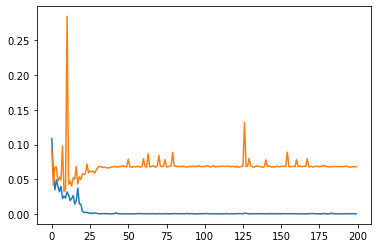

In [85]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [82]:
test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225])
                                    ])

In [83]:
test_dataset=datasets.ImageFolder('./test/',transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False)

In [84]:
acc=0
model.to(device)
with torch.no_grad(): 
    model.eval()
    for data, labels in tqdm(test_dataloader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        acc += torch.mean(equals.type(torch.float)).detach().cpu()
        
# calculate average losses
acc /= len(test_dataloader)
print('리멤버 team test accuracy: {:.6f}'.format(acc))

  0%|          | 0/89 [00:00<?, ?it/s]

리멤버 team test accuracy: 0.955056


In [49]:
model.load_state_dict(torch.load('hackaton1.pt'))

<All keys matched successfully>